# Application of pyKAN for 1D VLBI Data Interpolation

## Introduction

Introduction goes here.

## Imports

In [285]:
import torch
import numpy as np
import pandas as pd

from kan import *
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import warnings

## Precoded Functions

In [286]:
def cross_section(dataset, delta, alpha_deg, length=None):
    alpha = np.radians(alpha_deg)   
    distance = np.abs(dataset['U'] * np.sin(alpha) - dataset['V'] * np.cos(alpha))
    mask_distance = distance <= delta
    
    if length is not None:
        projection = dataset['U'] * np.cos(alpha) + dataset['V'] * np.sin(alpha)
        mask_length = np.abs(projection) <= length
        mask = mask_distance & mask_length
    else:
        mask = mask_distance
    
    filtered_data = dataset[mask].copy()
    
    print(f"Angle: {alpha_deg}, (deg.)")
    print(f"Cross-section width: {delta}")
    print(f"Number of points: {mask.sum()}/{len(dataset)} ({mask.sum()/len(dataset)*100:.1f}%)")
    
    return filtered_data, mask, distance

## Globals and Settings

In [287]:
# ignore warnings
warnings.filterwarnings(action="ignore")

In [288]:
# initialize torch device as `gpu` if exists else `cpu`
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using `{device}` device for torch.")

Using `cpu` device for torch.


In [289]:
DATASET_FILE = '.\data\Cres_05.txt'

In [290]:
TEST_SIZE = 0.25

In [291]:
# random seed global variable
RANDOM_STATE = 42

# Data Loading

In [292]:
# load data from text file indicated in DATASET_FILE global variable
dataset = pd.read_csv(DATASET_FILE, sep='\t')

In [293]:
# general information about dataset
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259200 entries, 0 to 259199
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   U       259200 non-null  float64
 1   V       259200 non-null  float64
 2   Re      259200 non-null  float64
 3   Im      259200 non-null  float64
dtypes: float64(4)
memory usage: 7.9 MB


## EDA

In [294]:
dataset['Baseline'] = np.sqrt(dataset['U']**2 + dataset['V']**2)
dataset['Amplitude'] = np.sqrt(dataset['Re']**2 + dataset['Im']**2)

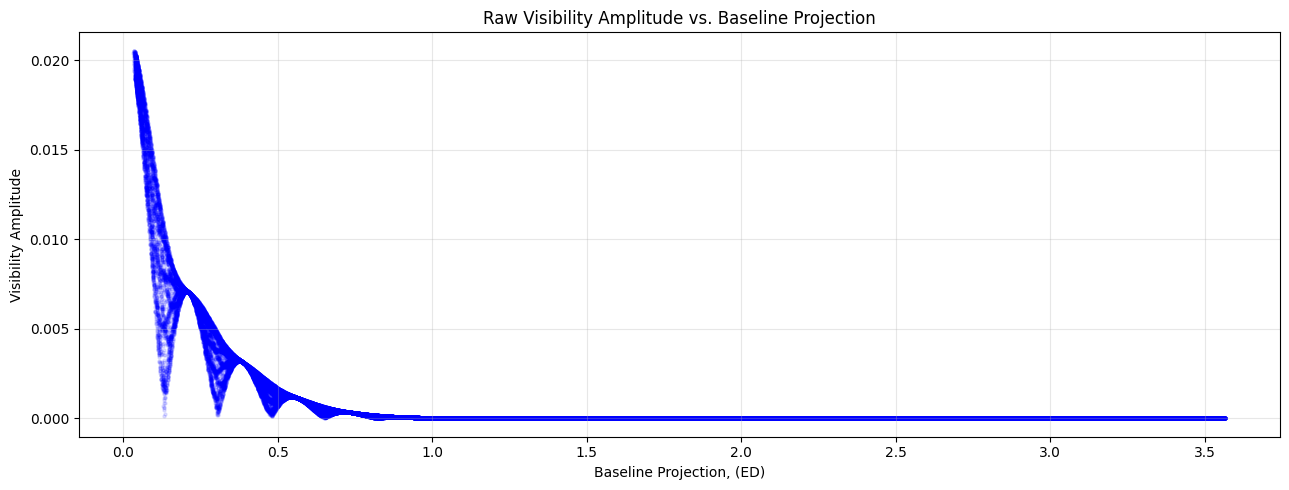

In [295]:
plt.figure(figsize=(13, 5))
plt.scatter(dataset['Baseline'], 
            dataset['Amplitude'], 
            alpha=0.1, 
            s=5,
            c='blue')
plt.xlabel('Baseline Projection, (ED)')
plt.ylabel('Visibility Amplitude')
plt.title('Raw Visibility Amplitude vs. Baseline Projection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [296]:
# extract visibility amplitude along the cross-section
delta_test = 0.01
alpha_test = 0

filtered_data, mask, distance = cross_section(dataset, 
                                              delta=delta_test, 
                                              alpha_deg=alpha_test)

Angle: 0, (deg.)
Cross-section width: 0.01
Number of points: 1606/259200 (0.6%)


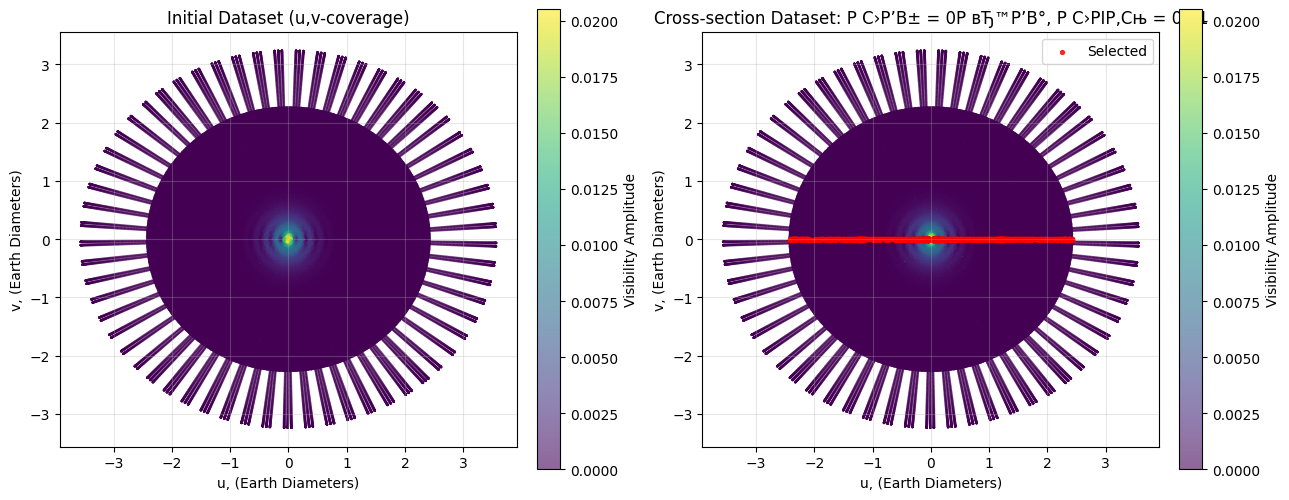

In [297]:
alpha_rad = np.radians(alpha_test)

projection = dataset['U'] * np.cos(alpha_rad) + dataset['V'] * np.sin(alpha_rad)
distance_to_line = np.abs(dataset['U'] * np.sin(alpha_rad) - dataset['V'] * np.cos(alpha_rad))
mask = distance_to_line <= delta_test

fig_uv, axs = plt.subplots(1, 2, figsize=(13, 6))

scatter_kwargs = dict(s=3, alpha=0.6, cmap='viridis', edgecolors='none')

sc1 = axs[0].scatter(dataset['U'], dataset['V'], c=dataset['Amplitude'], **scatter_kwargs)
axs[0].set_xlabel('u, (Earth Diameters)')
axs[0].set_ylabel('v, (Earth Diameters)')
axs[0].set_title('Initial Dataset (u,v-coverage)')
axs[0].set_aspect('equal')
axs[0].grid(True, alpha=0.3)
plt.colorbar(sc1, ax=axs[0], label='Visibility Amplitude', fraction=0.046, pad=0.04)

sc2 = axs[1].scatter(dataset['U'], dataset['V'], c=dataset['Amplitude'], **scatter_kwargs)
axs[1].set_xlabel('u, (Earth Diameters)')
axs[1].set_ylabel('v, (Earth Diameters)')
axs[1].set_title(f'Cross-section Dataset: Р С›Р’В± = {alpha_test}Р вЂ™Р’В°, Р С›РІР‚Сњ = {delta_test}')
axs[1].set_aspect('equal')
axs[1].grid(True, alpha=0.3)

cos_a, sin_a = np.cos(alpha_rad), np.sin(alpha_rad)
length = max(np.abs(projection).max(), 0.5) * 1.2
width_vec = np.array([-sin_a, cos_a]) * delta_test
length_vec = np.array([cos_a, sin_a]) * length
corners = [
    -length_vec/2 - width_vec,
    -length_vec/2 + width_vec,
    +length_vec/2 + width_vec,
    +length_vec/2 - width_vec
]
rect = plt.Polygon(corners, facecolor='none', edgecolor='red', linewidth=2, linestyle='--')
axs[1].add_patch(rect)

axs[1].scatter(dataset['U'][mask], dataset['V'][mask], c='red', s=8, alpha=0.8, label='Selected')
axs[1].legend()

plt.colorbar(sc2, ax=axs[1], label='Visibility Amplitude', fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

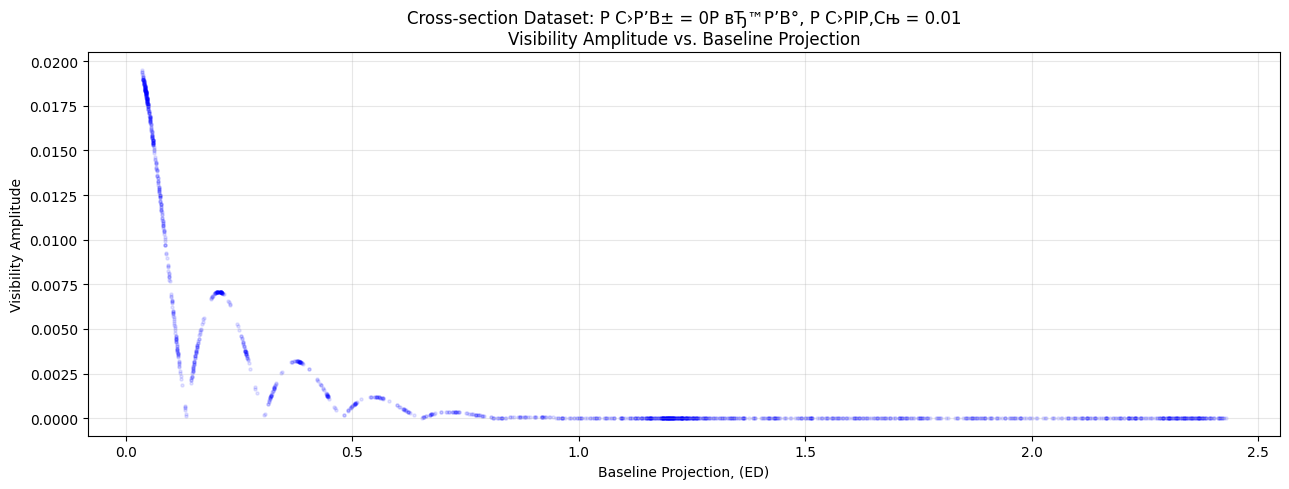

In [298]:
plt.figure(figsize=(13, 5))
plt.scatter(filtered_data['Baseline'], 
            filtered_data['Amplitude'], 
            alpha=0.1, 
            s=5,
            c='blue')
plt.xlabel('Baseline Projection, (ED)')
plt.ylabel('Visibility Amplitude')
plt.title(f'Cross-section Dataset: Р С›Р’В± = {alpha_test}Р вЂ™Р’В°, Р С›РІР‚Сњ = {delta_test}\nVisibility Amplitude vs. Baseline Projection')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [299]:
ranges = [
    (0.1, 0.2),
    (0.5, 0.6),
    (0.7, 0.8)
]

baseline_mask = pd.Series(False, index=filtered_data.index)

for start, stop in ranges:
    mask = filtered_data['Baseline'].between(start, stop)
    baseline_mask = baseline_mask | mask

selected_data = filtered_data[baseline_mask].copy()
rest_data = filtered_data[~baseline_mask].copy()

print(f"Selected baseline ranges: {ranges}")
print(f"Points selected: {len(selected_data):,} from {len(filtered_data):,} "
      f"({len(selected_data)/len(filtered_data)*100:.1f}%)")

Selected baseline ranges: [(0.1, 0.2), (0.5, 0.6), (0.7, 0.8)]
Points selected: 211 from 1,606 (13.1%)


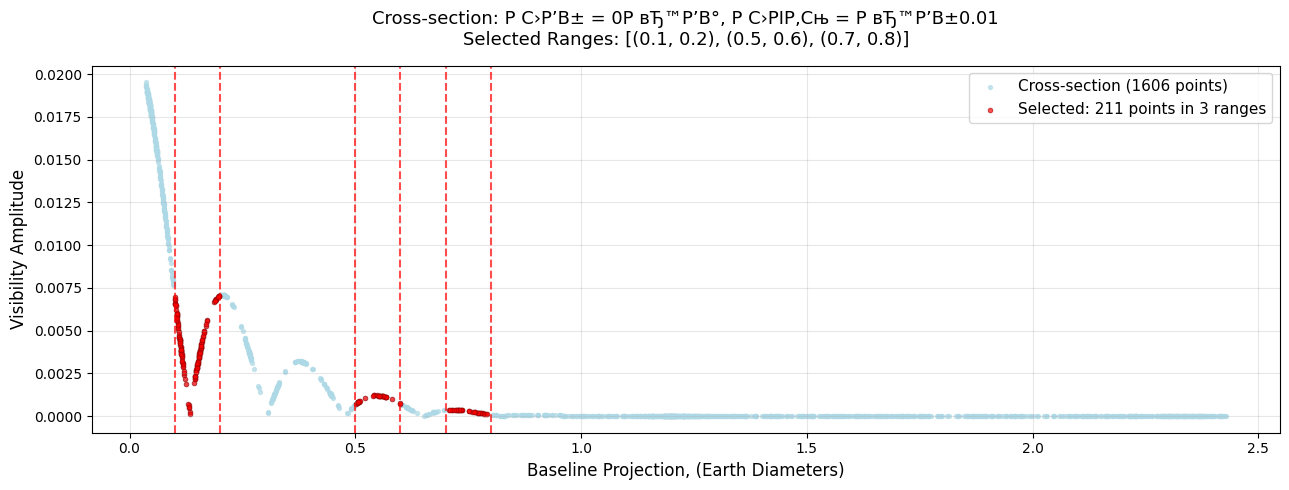

In [300]:
plt.figure(figsize=(13, 5))

plt.scatter(filtered_data['Baseline'],
            filtered_data['Amplitude'],
            alpha=0.65,
            s=8,
            c='lightblue',
            label=f'Cross-section ({len(filtered_data)} points)')

plt.scatter(selected_data['Baseline'],
            selected_data['Amplitude'],
            alpha=0.7,
            s=12,
            c='red',
            edgecolors='darkred',
            linewidth=0.5,
            label=f'Selected: {len(selected_data):,} points in {len(ranges)} ranges')


for i, (start, stop) in enumerate(ranges):
    plt.axvline(start, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axvline(stop, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

plt.xlabel('Baseline Projection, (Earth Diameters)', fontsize=12)
plt.ylabel('Visibility Amplitude', fontsize=12)
plt.title(f'Cross-section: Р С›Р’В± = {alpha_test}Р вЂ™Р’В°, Р С›РІР‚Сњ = Р вЂ™Р’В±{delta_test}\n'
          f'Selected Ranges: {ranges}',
          fontsize=13, pad=15)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

## Data Prepartion

In [301]:
rest_data = rest_data.sort_values('Baseline').reset_index(drop=True)

X_tensor = torch.from_numpy(rest_data[['Baseline']].values).float()
y_tensor = torch.from_numpy(rest_data[['Amplitude']].values).float()

In [302]:
dataset = create_dataset_from_data(X_tensor, y_tensor, train_ratio=1-TEST_SIZE, device=device)

In [303]:
print(dataset['train_input'].shape)
print(dataset['train_label'].shape)
print(dataset['test_input'].shape)
print(dataset['test_label'].shape)

torch.Size([1046, 1])
torch.Size([1046, 1])
torch.Size([349, 1])
torch.Size([349, 1])


## Model Initialization

In [313]:
# initialize model
model = KAN(width=[1, 8, 8, 1],
            grid=5,
            k=3,
            seed=RANDOM_STATE,
            device=device)


checkpoint directory created: ./model
saving model version 0.0


# Training

In [314]:
history = model.fit(dataset,
                    opt="LBFGS",
                    steps=1000,
                    update_grid=True);


| train_loss: 1.20e-04 | test_loss: 1.25e-04 | reg: 2.37e+01 | : 100%|█| 1000/1000 [04:53<00:00,  3.

saving model version 0.1


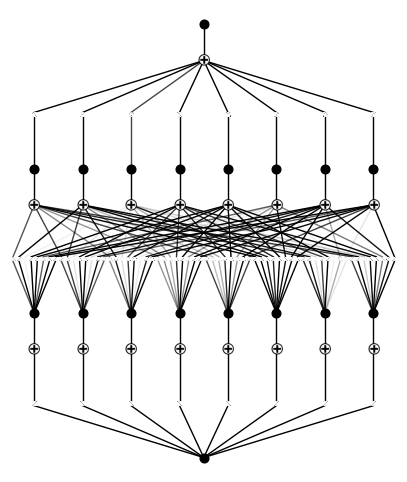

In [315]:
model.plot()

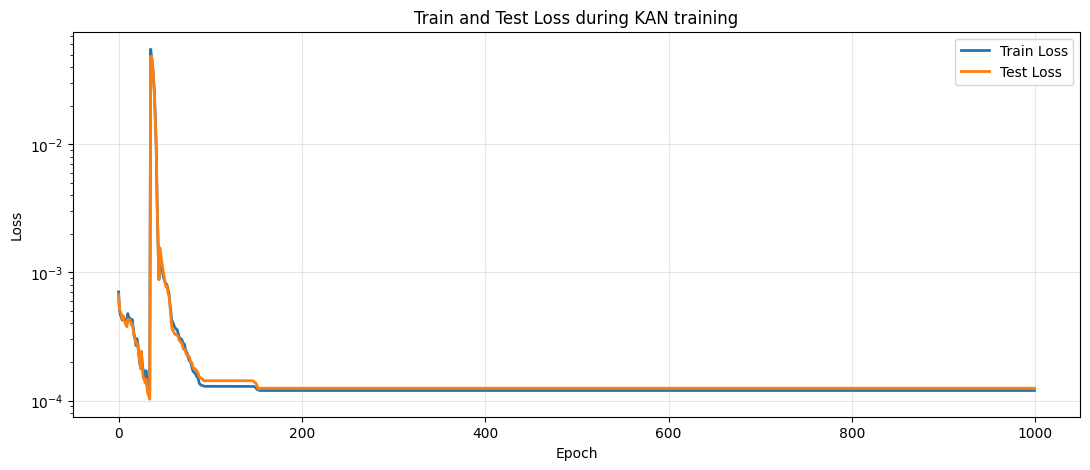

In [316]:
plt.figure(figsize=(13, 5))
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['test_loss'], label='Test Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss during KAN training')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.show()

# Model Testing

In [317]:
test_data = X_tensor = torch.from_numpy(selected_data[['Baseline']].values).float()
results = model(test_data)

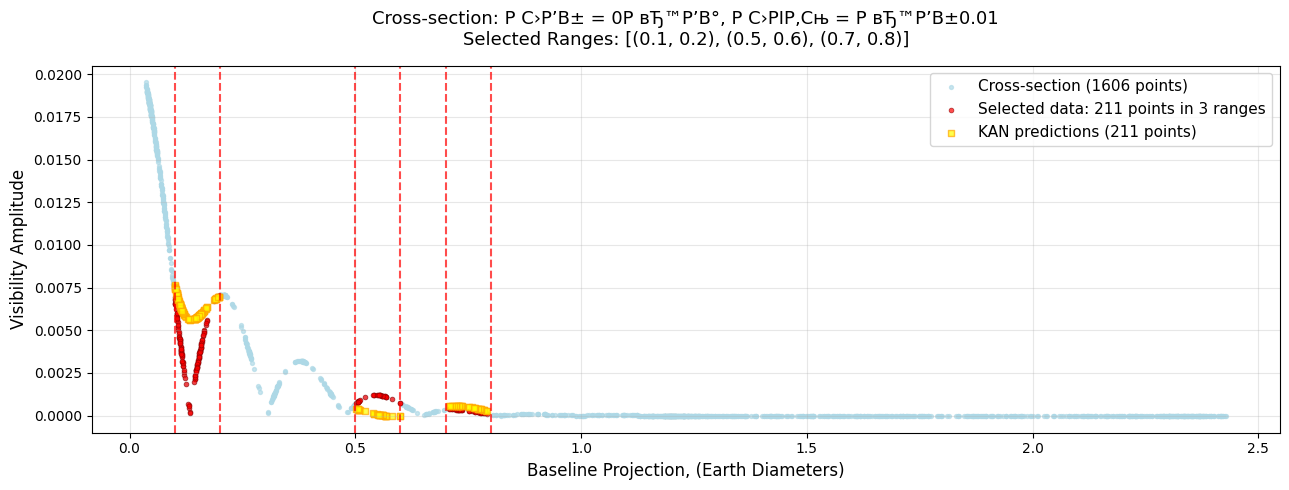

In [318]:
plt.figure(figsize=(13, 5))

plt.scatter(filtered_data['Baseline'],
            filtered_data['Amplitude'],
            alpha=0.65,
            s=8,
            c='lightblue',
            label=f'Cross-section ({len(filtered_data)} points)')

plt.scatter(selected_data['Baseline'],
            selected_data['Amplitude'],
            alpha=0.7,
            s=12,
            c='red',
            edgecolors='darkred',
            linewidth=0.5,
            label=f'Selected data: {len(selected_data):,} points in {len(ranges)} ranges')

plt.scatter(selected_data['Baseline'],
            results.detach().numpy(),
            alpha=0.7,
            s=25,
            c='yellow',
            edgecolors='orange',
            linewidth=1.0,
            marker='s',
            label=f'KAN predictions ({len(selected_data):,} points)')

for i, (start, stop) in enumerate(ranges):
    plt.axvline(start, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
    plt.axvline(stop, color='red', linestyle='--', alpha=0.7, linewidth=1.5)

plt.xlabel('Baseline Projection, (Earth Diameters)', fontsize=12)
plt.ylabel('Visibility Amplitude', fontsize=12)
plt.title(f'Cross-section: Р С›Р’В± = {alpha_test}Р вЂ™Р’В°, Р С›РІР‚Сњ = Р вЂ™Р’В±{delta_test}\n'
          f'Selected Ranges: {ranges}',
          fontsize=13, pad=15)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

In [319]:
whole_data = X_tensor = torch.from_numpy(filtered_data[['Baseline']].values).float()
results_whole = model(whole_data)

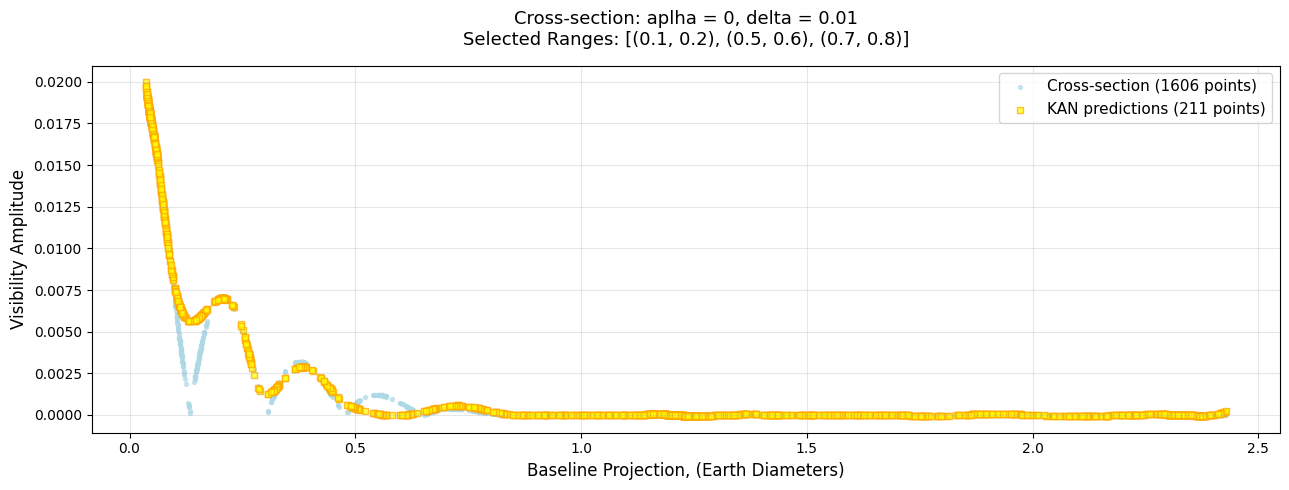

In [320]:
plt.figure(figsize=(13, 5))

plt.scatter(filtered_data['Baseline'],
            filtered_data['Amplitude'],
            alpha=0.65,
            s=8,
            c='lightblue',
            label=f'Cross-section ({len(filtered_data)} points)')

plt.scatter(filtered_data['Baseline'],
            results_whole.detach().numpy(),
            alpha=0.7,
            s=25,
            c='yellow',
            edgecolors='orange',
            linewidth=1.0,
            marker='s',
            label=f'KAN predictions ({len(selected_data):,} points)')

plt.xlabel('Baseline Projection, (Earth Diameters)', fontsize=12)
plt.ylabel('Visibility Amplitude', fontsize=12)
plt.title(f'Cross-section: aplha = {alpha_test}, delta = {delta_test}\n'
          f'Selected Ranges: {ranges}',
          fontsize=13, pad=15)

plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()

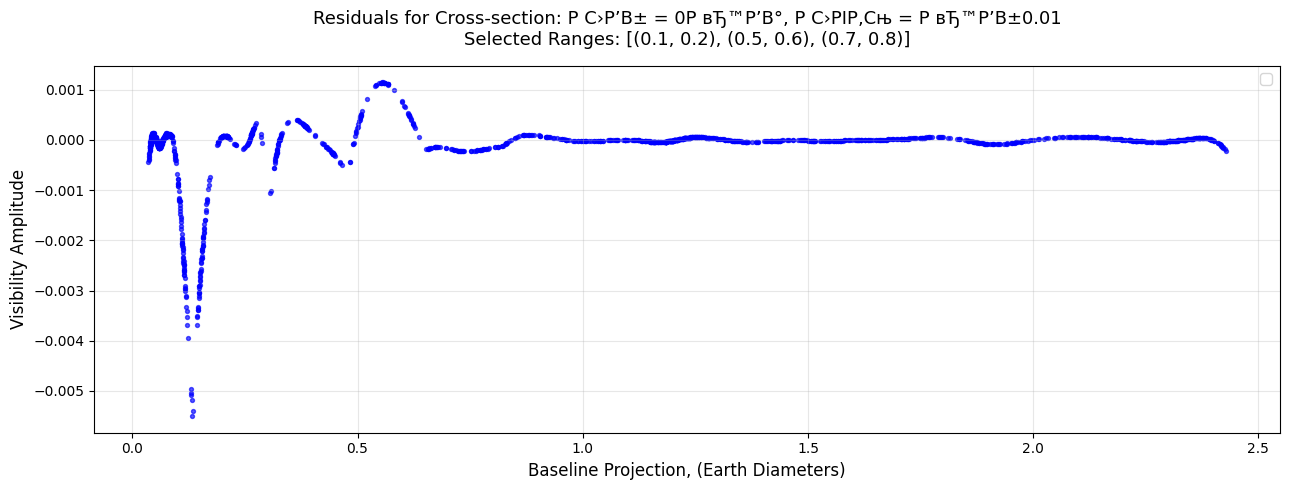

In [321]:
plt.figure(figsize=(13, 5))
plt.scatter(filtered_data['Baseline'],
            (filtered_data['Amplitude'] - results_whole.detach().numpy().flatten()),
            alpha=0.65,
            s=8,
            c='blue')
plt.xlabel('Baseline Projection, (Earth Diameters)', fontsize=12)
plt.ylabel('Visibility Amplitude', fontsize=12)
plt.title(f'Residuals for Cross-section: Р С›Р’В± = {alpha_test}Р вЂ™Р’В°, Р С›РІР‚Сњ = Р вЂ™Р’В±{delta_test}\n'
          f'Selected Ranges: {ranges}',
          fontsize=13, pad=15)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='upper right')
plt.tight_layout()
plt.show()
